In [66]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import precision_score as precision, recall_score as recall, accuracy_score as accuracy
from sklearn.model_selection import StratifiedKFold
import os

from graph import *
from graph_characteristic import *
from graph_simulate_statistics import *

# **Нагенерируем датасетиков для разных размеров выборок**

In [4]:
df_25 = generate_dataset(gen_gamma_points, gen_weibull_points, dataset_size=10000, num_vertex=25)
df_25.to_csv(os.path.join('..', 'data', 'df_25_vert_Student2.csv'), index=False)

100%|██████████| 5000/5000 [00:15<00:00, 327.55it/s] 


In [5]:
df_100 = generate_dataset(gen_gamma_points, gen_weibull_points, dataset_size=10000, num_vertex=100)
df_100.to_csv(os.path.join('..', 'data', 'df_100_vert_Student2.csv'), index=False)

100%|██████████| 5000/5000 [06:17<00:00, 13.25it/s]


In [6]:
df_500 = generate_dataset(gen_gamma_points, gen_weibull_points, dataset_size=10000, num_vertex=500)
df_500.to_csv(os.path.join('..', 'data', 'df_500_vert_Student2.csv'), index=False)

100%|██████████| 5000/5000 [8:26:38<00:00,  6.08s/it]    


# **Поехали обучать**

In [67]:
df_25 = pd.read_csv(os.path.join('..', 'data', 'df_25_vert_Student2.csv'))
df_100 = pd.read_csv(os.path.join('..', 'data', 'df_100_vert_Student2.csv'))
df_500 = pd.read_csv(os.path.join('..', 'data', 'df_500_vert_Student2.csv'))

## **Базовые модели**

In [69]:
for n, df in zip([25, 100, 500], [df_25, df_100, df_500]):
    X, y = df.drop('distribution', axis = 1), df['distribution']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=239, stratify=y)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = LogisticRegression(max_iter=1000, class_weight='balanced')
    model.fit(X_train_scaled, y_train)
    y_pred_logistic = model.predict(X_test_scaled)


    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    y_pred_linear = (model.predict(X_test_scaled) > 0.5).astype(int)


    model = Ridge()
    model.fit(X_train_scaled, y_train)
    y_pred_ridge = (model.predict(X_test_scaled) > 0.5).astype(int)

    model = Lasso()
    model.fit(X_train_scaled, y_train)
    y_pred_lasso = (model.predict(X_test_scaled) > 0.5).astype(int)

    print(f"N = {n}")
    print('\tLogistic')
    print("\t\tPrecision:", precision(y_test, y_pred_logistic))
    print("\t\tAccuracy:", accuracy(y_test, y_pred_logistic))
    print("\t\tRecall:", recall(y_test, y_pred_logistic), "\n")

    print('\tLinear')
    print("\t\tPrecision:", precision(y_test, y_pred_linear))
    print("\t\tAccuracy:", accuracy(y_test, y_pred_linear))
    print("\t\trecall:", recall(y_test, y_pred_linear), "\n")

    print('\tRidge')
    print("\t\tPrecision:", precision(y_test, y_pred_ridge))
    print("\t\tAccuracy:", accuracy(y_test, y_pred_ridge))
    print("\t\trecall:", recall(y_test, y_pred_ridge), "\n")
    


N = 25
	Logistic
		Precision: 0.8071476736345247
		Accuracy: 0.8036666666666666
		Recall: 0.798 

	Linear
		Precision: 0.8426132145508537
		Accuracy: 0.8076666666666666
		recall: 0.7566666666666667 

	Ridge
		Precision: 0.8426132145508537
		Accuracy: 0.8076666666666666
		recall: 0.7566666666666667 

N = 100
	Logistic
		Precision: 0.9699599465954606
		Accuracy: 0.9693333333333334
		Recall: 0.9686666666666667 

	Linear
		Precision: 0.9907473309608541
		Accuracy: 0.9596666666666667
		recall: 0.928 

	Ridge
		Precision: 0.9907473309608541
		Accuracy: 0.9596666666666667
		recall: 0.928 

N = 500
	Logistic
		Precision: 1.0
		Accuracy: 0.9993333333333333
		Recall: 0.9986666666666667 

	Linear
		Precision: 1.0
		Accuracy: 0.9993333333333333
		recall: 0.9986666666666667 

	Ridge
		Precision: 1.0
		Accuracy: 0.9993333333333333
		recall: 0.9986666666666667 



**Результаты достаточно хороши!** видим что особой разницы качества между линейными моделями нет.

## **Оценим дисперсию метрик**

Для этого зафиксируем модель - **логистическую регрессию**, и проведем кроссвалидацию.

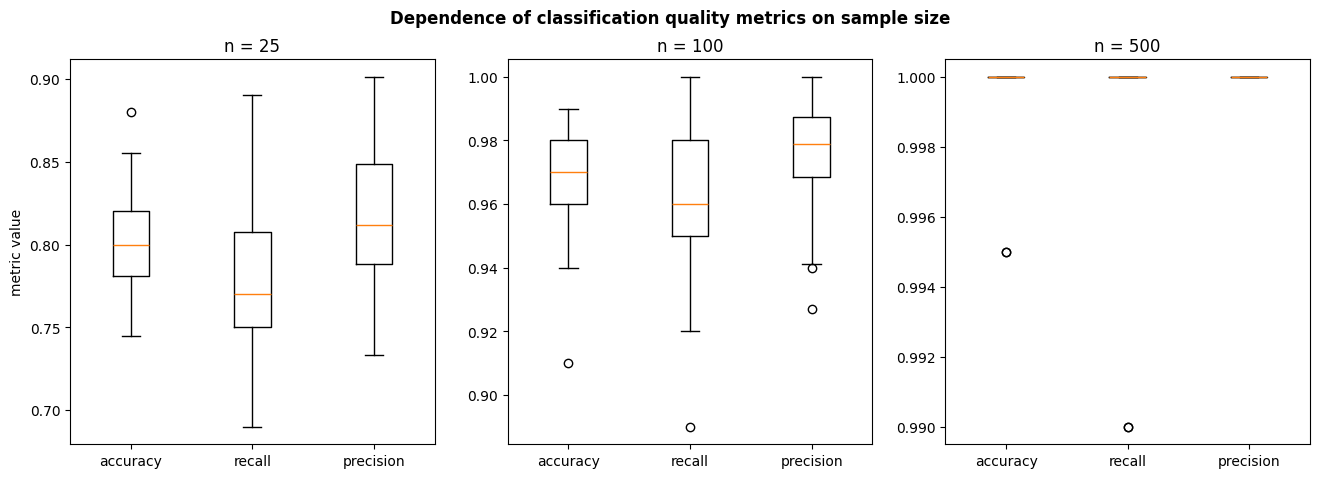

N = 25
	Accuracy dispersion =  0.000843239999999999
	Recall dispersion =  0.002070560000000001
	Precision dispersion =  0.001406467730782452
N = 100
	Accuracy dispersion =  0.0002182100000000001
	Recall dispersion =  0.0004425599999999999
	Precision dispersion =  0.0002692539474231832
N = 500
	Accuracy dispersion =  9.600000000000018e-07
	Recall dispersion =  3.840000000000007e-06
	Precision dispersion =  0.0


In [117]:
plt.figure(figsize=(16,5))
plt.suptitle("Dependence of classification quality metrics on sample size", fontweight='bold')

dispersions = []

for idx, n, df in zip([0, 1, 2], [25, 100, 500], [df_25, df_100, df_500]):
    X, y = df.drop('distribution', axis = 1), df['distribution']
    
    cv = StratifiedKFold(n_splits=50, shuffle=True, random_state=52)
    metrics = [[], [], []]

    for train_idx, valid_idx in cv.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_valid_scaled = scaler.transform(X_valid)

        model = LogisticRegression(max_iter=1000, class_weight='balanced')
        model.fit(X_train_scaled, y_train)
        prediction = model.predict(X_valid_scaled)
        metrics[0].append(accuracy(y_valid, prediction))
        metrics[1].append(recall(y_valid, prediction))
        metrics[2].append(precision(y_valid, prediction))

    dispersions.append([np.var(metrics[0]), np.var(metrics[1]), np.var(metrics[2])])

    plt.subplot(1, 3, idx + 1)
    plt.title(f"n = {n}")
    plt.boxplot(metrics, tick_labels=['accuracy', 'recall', 'precision'])
    if idx == 0:
        plt.ylabel("metric value")

plt.show()

for n, vars in zip([25, 100, 500], dispersions):
    print(f"N = {n}")
    print("\tAccuracy dispersion = ", vars[0])
    print("\tRecall dispersion = ", vars[1])
    print("\tPrecision dispersion = ", vars[2])

## **Посмотрим на важность характеристик с точки зрения классификация при различных $n$.**

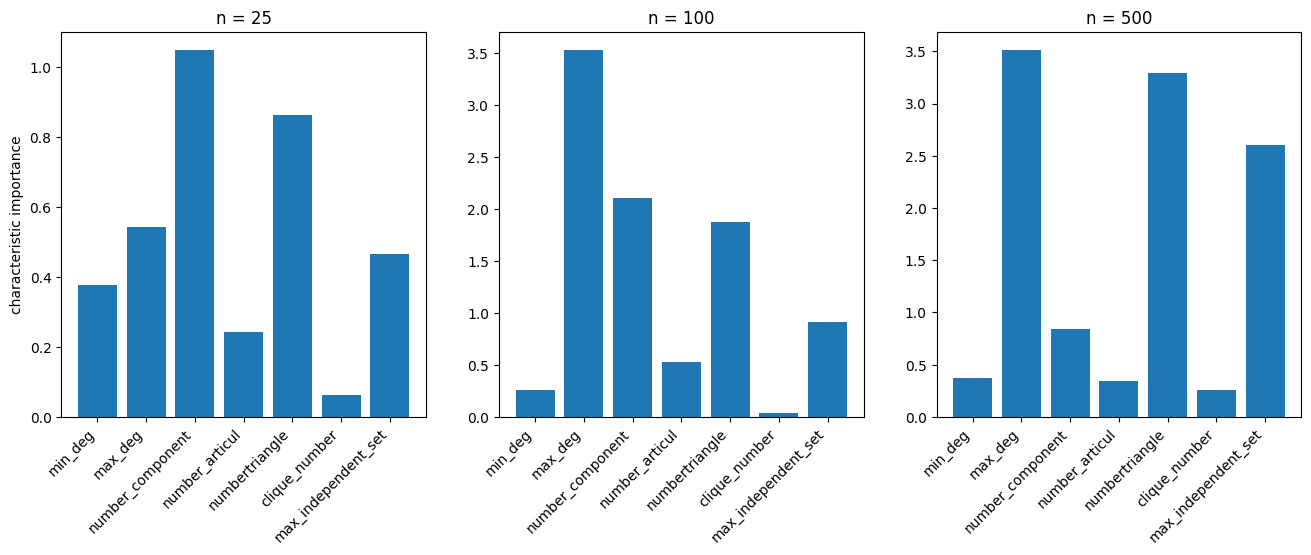

In [100]:
plt.figure(figsize=(16,5))

features = df_25.drop(['distribution'], axis = 1).columns

for idx, n, df in zip([0, 1, 2], [25, 100, 500], [df_25, df_100, df_500]):

    X, y = df.drop('distribution', axis = 1), df['distribution']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=239, stratify=y)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    plt.subplot(1, 3, idx + 1)
    plt.title(f"n = {n}")
    model = LogisticRegression()
    model.fit(X_train_scaled, y_train)
    plt.bar(features, np.abs(model.coef_[0]))
    plt.xticks(rotation=45, ha='right')
    if idx == 0:
        plt.ylabel("characteristic importance")

plt.show()

Видим, что с увеличением размера выборки важность признаков, с точки зрения классификации, меняется.